**Employee Attrition Analysis using Logistic Regression**

* Step 1 - Correlation Analysis

* Step 2 - Create Logistic Regression Model

* Step 3 - Feature Importance from Logistic Regression

* Step 4 - Model Optimization and Evaluation

In [1]:
# Import dependencies
import psycopg2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import RFE

# Import password
from password import postgres_password

Step 1 - Correlation Analysis:

First, we'll analyze the correlations between features and the target variable (Attrition).

In [2]:
# Establish the connection to postgres database
conn = psycopg2.connect(database = "project_4",
                        user = "postgres",
                        password = postgres_password,
                        host = "localhost",
                        port = "5432"
)

# Import and read the employee_attrition.csv from SQL
attrition_df = pd.read_sql_query('''SELECT * FROM attrition''', conn)

# Close the connection
conn.close()

C:\Users\danie\AppData\Local\Temp\ipykernel_24520\4226612750.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  attrition_df = pd.read_sql_query('''SELECT * FROM attrition''', conn)


In [3]:
# Review dataframe
attrition_df.head()

,age,attrition,businesstravel,dailyrate,department,distancefromhome,education,educationfield,employeecount,employeenumber,...,relationshipsatisfaction,standardhours,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [4]:
# Determine the number of unique values in each column.
attrition_df.nunique()

age                           43
attrition                      2
businesstravel                 3
dailyrate                    886
department                     3
distancefromhome              29
education                      5
educationfield                 6
employeecount                  1
employeenumber              1470
environmentsatisfaction        4
gender                         2
hourlyrate                    71
jobinvolvement                 4
joblevel                       5
jobrole                        9
jobsatisfaction                4
maritalstatus                  3
monthlyincome               1349
monthlyrate                 1427
numcompaniesworked            10
over18                         1
overtime                       2
percentsalaryhike             15
performancerating              2
relationshipsatisfaction       4
standardhours                  1
stockoptionlevel               4
totalworkingyears             40
trainingtimeslastyear          7
worklifeba

In [5]:
# Drop unnecessary and redundant columns
del attrition_df["employeecount"]
del attrition_df["employeenumber"]
del attrition_df["over18"]
del attrition_df["standardhours"]

# Drop "Rate" columns as they may be redundant
del attrition_df["dailyrate"]
del attrition_df["hourlyrate"]
del attrition_df["monthlyrate"]

attrition_df.head()

,age,attrition,businesstravel,department,distancefromhome,education,educationfield,environmentsatisfaction,gender,jobinvolvement,...,performancerating,relationshipsatisfaction,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager
0,41,Yes,Travel_Rarely,Sales,1,2,Life Sciences,2,Female,3,...,3,1,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,Research & Development,8,1,Life Sciences,3,Male,2,...,4,4,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,Research & Development,2,2,Other,4,Male,2,...,3,2,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,Research & Development,3,4,Life Sciences,4,Female,3,...,3,3,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,Research & Development,2,1,Medical,1,Male,3,...,3,4,1,6,3,3,2,2,2,2


In [6]:
# Create a custum function to encode binary columns
def encode_column(column):
    if (column == "Yes") | (column == "Male"):
        return 1
    else:
        return 0

In [7]:
# Apply custom function to columns with binary data
attrition_df["attrition"] = attrition_df["attrition"].apply(encode_column)
attrition_df["gender"] = attrition_df["gender"].apply(encode_column)
attrition_df["overtime"] = attrition_df["overtime"].apply(encode_column)
attrition_df.head()

,age,attrition,businesstravel,department,distancefromhome,education,educationfield,environmentsatisfaction,gender,jobinvolvement,...,performancerating,relationshipsatisfaction,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager
0,41,1,Travel_Rarely,Sales,1,2,Life Sciences,2,0,3,...,3,1,0,8,0,1,6,4,0,5
1,49,0,Travel_Frequently,Research & Development,8,1,Life Sciences,3,1,2,...,4,4,1,10,3,3,10,7,1,7
2,37,1,Travel_Rarely,Research & Development,2,2,Other,4,1,2,...,3,2,0,7,3,3,0,0,0,0
3,33,0,Travel_Frequently,Research & Development,3,4,Life Sciences,4,0,3,...,3,3,0,8,3,3,8,7,3,0
4,27,0,Travel_Rarely,Research & Development,2,1,Medical,1,1,3,...,3,4,1,6,3,3,2,2,2,2


In [8]:
# Encode categorical data to numeric with "pd.get_dummies"
converted_df = pd.get_dummies(attrition_df, columns=["businesstravel", "department", "educationfield", "jobrole", "maritalstatus"], dtype="int")
converted_df.head()

,age,attrition,distancefromhome,education,environmentsatisfaction,gender,jobinvolvement,joblevel,jobsatisfaction,monthlyincome,...,jobrole_Laboratory Technician,jobrole_Manager,jobrole_Manufacturing Director,jobrole_Research Director,jobrole_Research Scientist,jobrole_Sales Executive,jobrole_Sales Representative,maritalstatus_Divorced,maritalstatus_Married,maritalstatus_Single
0,41,1,1,2,2,0,3,2,4,5993,...,0,0,0,0,0,1,0,0,0,1
1,49,0,8,1,3,1,2,2,2,5130,...,0,0,0,0,1,0,0,0,1,0
2,37,1,2,2,4,1,2,1,3,2090,...,1,0,0,0,0,0,0,0,0,1
3,33,0,3,4,4,0,3,1,3,2909,...,0,0,0,0,1,0,0,0,1,0
4,27,0,2,1,1,1,3,1,2,3468,...,1,0,0,0,0,0,0,0,1,0


attrition                            1.000000
overtime                             0.246118
maritalstatus_Single                 0.175419
jobrole_Sales Representative         0.157234
businesstravel_Travel_Frequently     0.115143
jobrole_Laboratory Technician        0.098290
department_Sales                     0.080855
distancefromhome                     0.077924
educationfield_Technical Degree      0.069355
educationfield_Marketing             0.055781
numcompaniesworked                   0.043494
educationfield_Human Resources       0.036466
jobrole_Human Resources              0.036215
gender                               0.029453
jobrole_Sales Executive              0.019774
department_Human Resources           0.016832
performancerating                    0.002889
jobrole_Research Scientist          -0.000360
percentsalaryhike                   -0.013478
educationfield_Other                -0.017898
education                           -0.031373
educationfield_Life Sciences      

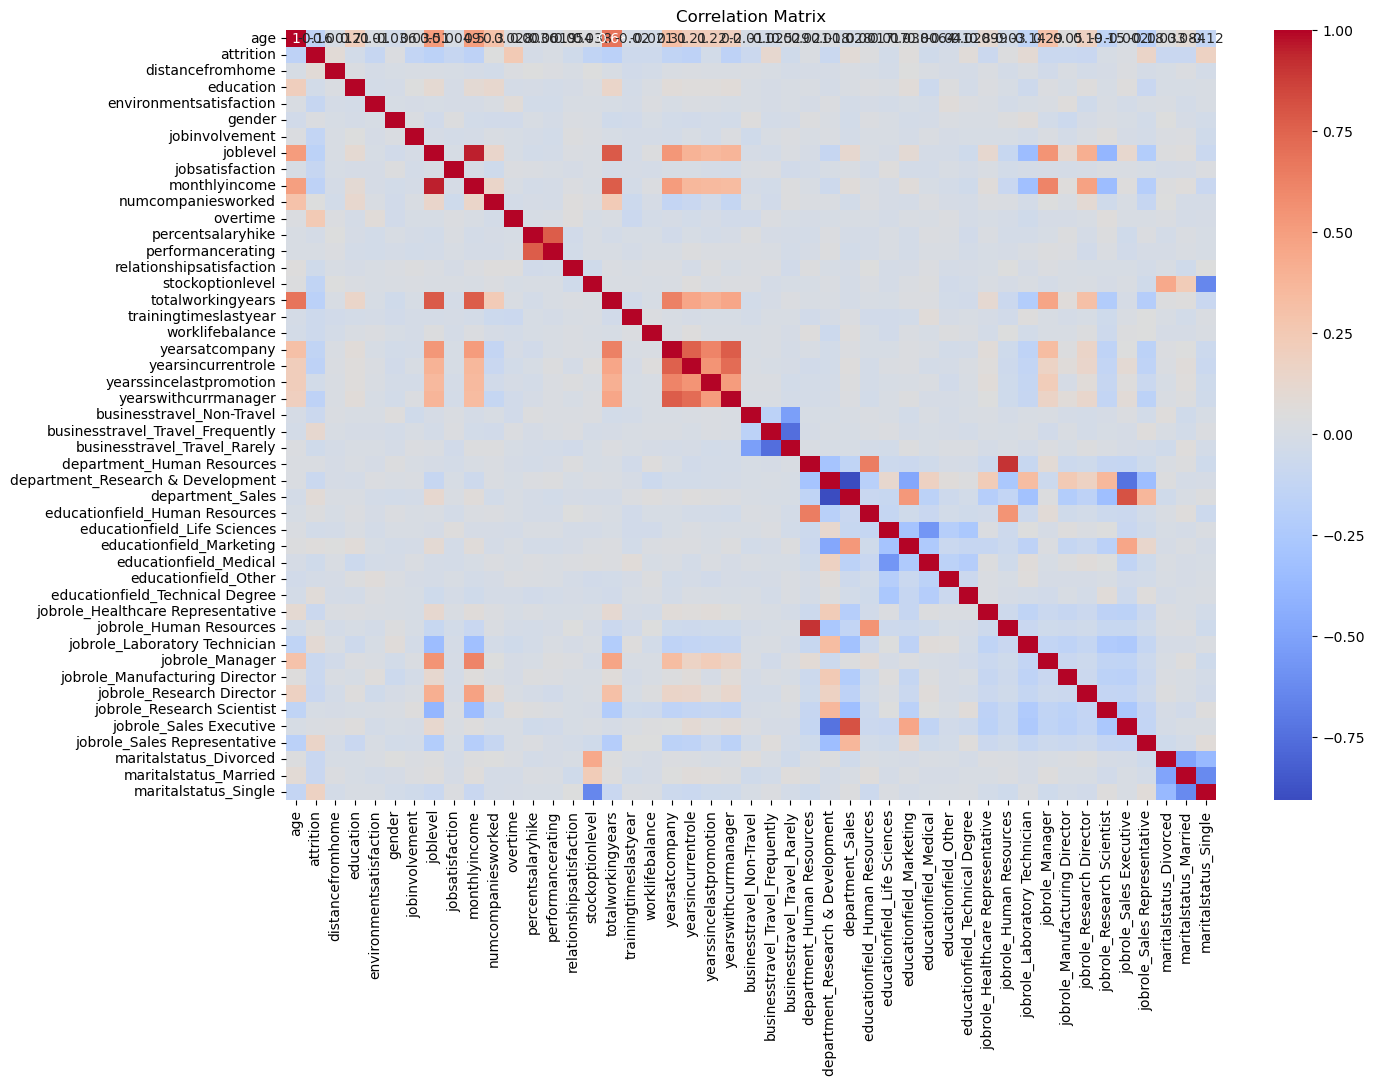

In [9]:
# Compute the correlation matrix
corr_matrix = converted_df.corr()

# Correlation with target variable 'Attrition_Yes'
corr_target = corr_matrix["attrition"].sort_values(ascending=False)
print(corr_target)

# Visualize the correlation matrix
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.savefig("output/logistic_regression_correlation_matrix", bbox_inches = 'tight')
plt.show()


Step 2 - Create a Logistic Regression Model

In [10]:
# Split our preprocessed data into our features and target arrays
y = converted_df["attrition"]
X = converted_df.drop(columns=["attrition"])

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=1,
                                                    stratify=y)

In [11]:
# Review targets
pd.DataFrame(y).head()

,attrition
0,1
1,0
2,1
3,0
4,0


In [12]:
# Review features
X.head()

,age,distancefromhome,education,environmentsatisfaction,gender,jobinvolvement,joblevel,jobsatisfaction,monthlyincome,numcompaniesworked,...,jobrole_Laboratory Technician,jobrole_Manager,jobrole_Manufacturing Director,jobrole_Research Director,jobrole_Research Scientist,jobrole_Sales Executive,jobrole_Sales Representative,maritalstatus_Divorced,maritalstatus_Married,maritalstatus_Single
0,41,1,2,2,0,3,2,4,5993,8,...,0,0,0,0,0,1,0,0,0,1
1,49,8,1,3,1,2,2,2,5130,1,...,0,0,0,0,1,0,0,0,1,0
2,37,2,2,4,1,2,1,3,2090,6,...,1,0,0,0,0,0,0,0,0,1
3,33,3,4,4,0,3,1,3,2909,1,...,0,0,0,0,1,0,0,0,1,0
4,27,2,1,1,1,3,1,2,3468,9,...,1,0,0,0,0,0,0,0,1,0


In [13]:
# Create logistic regerssion model
model = LogisticRegression(solver="lbfgs",
                                max_iter=200,
                                random_state=1)
model

LogisticRegression(max_iter=200, random_state=1)

In [14]:
# Fit training data to model
model.fit(X_train, y_train)

c:\Users\danie\anaconda3\envs\dev\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=200, random_state=1)

In [15]:
# Make predictions on testing data
predictions = model.predict(X_test)
results = pd.DataFrame({"Prediction": predictions, "Actual": y_test}).reset_index(drop=True)
results.head()

,Prediction,Actual
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [16]:
# Display the accuracy score for the test dataset.
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, predictions)}")

Logistic Regression Accuracy: 0.8505434782608695


In [17]:
# Print the classification report for the model
target_names = ["Attrition", "No Attrition"]
print(classification_report(y_test, predictions, target_names = target_names))

              precision    recall  f1-score   support

   Attrition       0.86      0.99      0.92       309
No Attrition       0.67      0.14      0.23        59

    accuracy                           0.85       368
   macro avg       0.76      0.56      0.57       368
weighted avg       0.83      0.85      0.81       368



In [18]:
# Generate the confusion matrix for the model
conf_matrix = confusion_matrix(y_test, predictions)
conf_matrix


array([[305,   4],
       [ 51,   8]], dtype=int64)

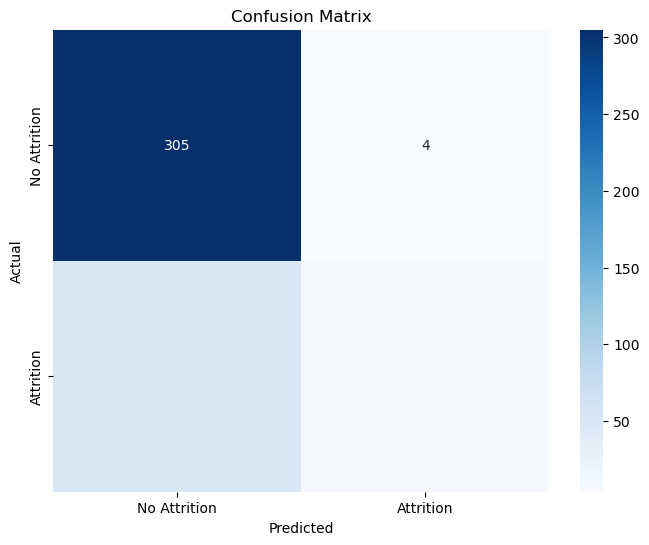

In [19]:
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Attrition", "Attrition"], yticklabels=["No Attrition", "Attrition"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.savefig("output/logistic_regression_confusion_matrix", bbox_inches = 'tight')
plt.show()